In [1]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import utils

In [2]:
rotations = np.array([(np.pi/2 + n*np.pi/8)%(2*np.pi) for n in range(16)])
cardinals_map = dict(zip(utils.CARDINALS, rotations))

In [3]:
class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        current_decayed_lr = self.model.optimizer._decayed_lr(tf.float32).numpy()
        print(f"Current Learning Rate =  {current_decayed_lr}")

In [4]:
df1 = pd.read_csv("weatherAUS.csv.zip")
df1 = utils.process_data(df1, cardinals_map)
df2 = pd.read_csv("weatherAUS_second_source.csv.zip")  # from https://rdrr.io/cran/rattle.data/man/weatherAUS.html
df2 = utils.process_data(df2, cardinals_map)
df = pd.concat([df1, df2])
del df1; del df2; gc.collect()
df.drop_duplicates(subset=["Date", "Location"], keep="first", inplace=True)
df.sort_values(by=["Date", "Location"], inplace=True, ignore_index=True)
df.drop(columns=["Date", "RainToday"], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["RainTomorrow"]), df["RainTomorrow"], test_size=0.25, shuffle=False
)

del df; gc.collect()


X_train["Evaporation"] = X_train.groupby("Location")["Evaporation"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 100)
X_train["Sunshine"] = X_train.groupby("Location")["Sunshine"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 20)
X_train["Cloud9am"] = X_train.groupby("Location")["Cloud9am"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 9)
X_train["Cloud3pm"] = X_train.groupby("Location")["Cloud3pm"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 9)

X_test["Evaporation"] = X_test.groupby("Location")["Evaporation"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 100)
X_test["Sunshine"] = X_test.groupby("Location")["Sunshine"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 20)
X_test["Cloud9am"] = X_test.groupby("Location")["Cloud9am"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 9)
X_test["Cloud3pm"] = X_test.groupby("Location")["Cloud3pm"].apply(lambda s: utils.walk_forward_extrapolate(s)).clip(0, 9)

X_train.update(X_train.groupby("Location").ffill())
X_test.update(X_test.groupby("Location").ffill())

dry_reads = X_train.groupby("Location")["Rainfall"].apply(utils.running_zero_count_with_reset).rename("RunningDryReads")
X_train = X_train.merge(dry_reads, left_index=True, right_index=True)

dry_reads = X_test.groupby("Location")["Rainfall"].apply(utils.running_zero_count_with_reset).rename("RunningDryReads")
X_test = X_test.merge(dry_reads, left_index=True, right_index=True)

for col in X_train:
    X_train[col] = X_train[col].fillna(utils.DEFAULT_VALS.get(col, np.nan))

for col in X_test:
    X_test[col] = X_test[col].fillna(utils.DEFAULT_VALS.get(col, np.nan))

cols_to_lag = ["Temp3pm", "Humidity3pm", "Pressure3pm",
               "Temp9am", "Humidity9am", "Pressure9am"]

X_train = utils.feature_transformer(X_train)
X_test = utils.feature_transformer(X_test)

lags = [1, 2, 3, 4, 5]

for lag in lags:
    shifted = X_train.groupby("Location")[cols_to_lag].shift(lag)
    shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG{lag}")
    X_train = X_train.merge(shifted, left_index=True, right_index=True)

    shifted = X_test.groupby("Location")[cols_to_lag].shift(lag)
    shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG{lag}")
    X_test = X_test.merge(shifted, left_index=True, right_index=True)


for col in cols_to_lag:
    for lag in lags:
        X_train[f"{col}_LAG{lag}"] = X_train[f"{col}_LAG{lag}"].fillna(utils.DEFAULT_VALS.get(col, np.nan))
        X_test[f"{col}_LAG{lag}"] = X_test[f"{col}_LAG{lag}"].fillna(utils.DEFAULT_VALS.get(col, np.nan))

X_train.info(show_counts=True)
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154177 entries, 0 to 154176
Data columns (total 75 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Location            154177 non-null  object 
 1   MinTemp             154177 non-null  float64
 2   MaxTemp             154177 non-null  float64
 3   Rainfall            154177 non-null  float64
 4   Evaporation         154177 non-null  float64
 5   Sunshine            154177 non-null  float64
 6   WindGustSpeed       154177 non-null  float64
 7   WindSpeed9am        154177 non-null  float64
 8   WindSpeed3pm        154177 non-null  float64
 9   Humidity9am         154177 non-null  float64
 10  Humidity3pm         154177 non-null  float64
 11  Pressure9am         154177 non-null  float64
 12  Pressure3pm         154177 non-null  float64
 13  Cloud9am            154177 non-null  float64
 14  Cloud3pm            154177 non-null  float64
 15  Temp9am             154177 non-nul

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,Pressure3pm_LAG4,Temp9am_LAG4,Humidity9am_LAG4,Pressure9am_LAG4,Temp3pm_LAG5,Humidity3pm_LAG5,Pressure3pm_LAG5,Temp9am_LAG5,Humidity9am_LAG5,Pressure9am_LAG5
0,Canberra,8.0,24.3,0.0,3.4,6.3,30.0,6.0,20.0,68.0,...,1015.0,15.0,70.0,1015.0,20.0,60.0,1015.0,15.0,70.0,1015.0
1,Canberra,14.0,26.9,3.6,4.4,9.7,39.0,4.0,17.0,80.0,...,1015.0,15.0,70.0,1015.0,20.0,60.0,1015.0,15.0,70.0,1015.0
2,Canberra,13.7,23.4,3.6,5.8,3.3,85.0,6.0,6.0,82.0,...,1015.0,15.0,70.0,1015.0,20.0,60.0,1015.0,15.0,70.0,1015.0
3,Canberra,13.3,15.5,39.8,7.2,9.1,54.0,30.0,24.0,62.0,...,1015.0,15.0,70.0,1015.0,20.0,60.0,1015.0,15.0,70.0,1015.0
4,Canberra,7.6,16.1,2.8,5.6,10.6,50.0,20.0,28.0,68.0,...,1015.0,14.4,68.0,1019.7,20.0,60.0,1015.0,15.0,70.0,1015.0


In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

y_train.drop(y_train.head(1).index, inplace=True)
y_valid.drop(y_valid.head(1).index, inplace=True)
y_test.drop(y_test.head(1).index, inplace=True)

In [6]:
X_train = utils.scaler(X_train)
X_valid = utils.scaler(X_valid)
X_test = utils.scaler(X_test)
print(X_train.shape, X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(123340, 75) (30835, 75) (51392, 75)
(123340,) (30835,) (51392,)


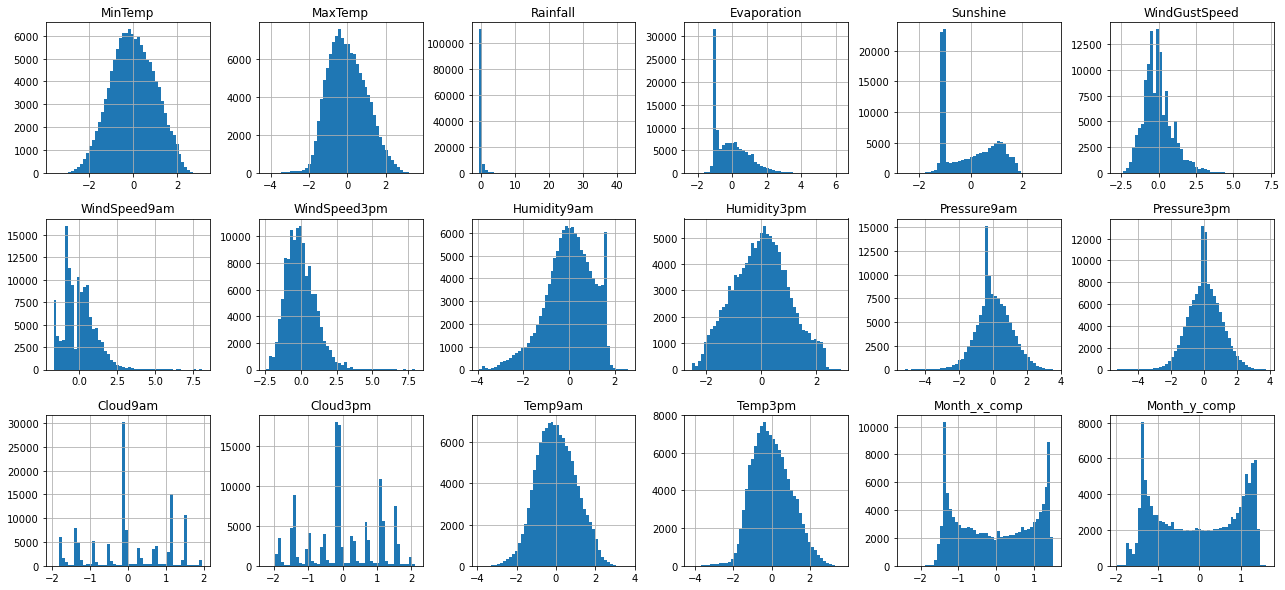

In [7]:
X_train[X_train.columns[:18]].hist(figsize=(22, 10), bins=50, layout=(3, 6));

In [8]:
def create_model(input_dim=57):
    model = keras.Sequential(
        [
            keras.layers.Dense(512, input_dim=input_dim, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(128, activation="relu"),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, activation="relu"),
            keras.layers.Dense(1, activation="sigmoid")
        ]
    )
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.001, decay_steps=5000, decay_rate=0.9, staircase=True
)

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["accuracy"]
    )
    return model

In [9]:
model = create_model(len(X_train.columns) - 1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               38400     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 112,385
Trainable params: 112,385
Non-trainable params: 0
__________________________________________________

In [10]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("deep_nn.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=25, restore_best_weights=True)

history = model.fit(
    X_train.drop(columns=["Location"]),
    y_train,
    validation_data=(X_valid.drop(columns=["Location"]), y_valid),
    epochs=150,
    batch_size=64,
    callbacks=[early_stopping_cb, checkpoint_cb, LearningRateLogger()]
)

Epoch 1/150
Current Learning Rate =  0.0010000000474974513
1928/1928 [==============================] - 7s 3ms/step - loss: 0.3806 - accuracy: 0.8354 - val_loss: 0.3638 - val_accuracy: 0.8464
Epoch 2/150
Current Learning Rate =  0.0010000000474974513
1928/1928 [==============================] - 6s 3ms/step - loss: 0.3436 - accuracy: 0.8536 - val_loss: 0.3559 - val_accuracy: 0.8498
Epoch 3/150
Current Learning Rate =  0.0010000000474974513
1928/1928 [==============================] - 5s 3ms/step - loss: 0.3383 - accuracy: 0.8553 - val_loss: 0.3502 - val_accuracy: 0.8496
Epoch 4/150
Current Learning Rate =  0.0009000000427477062
1928/1928 [==============================] - 4s 2ms/step - loss: 0.3316 - accuracy: 0.8595 - val_loss: 0.3481 - val_accuracy: 0.8508
Epoch 5/150
Current Learning Rate =  0.0009000000427477062
1928/1928 [==============================] - 5s 3ms/step - loss: 0.3312 - accuracy: 0.8572 - val_loss: 0.3509 - val_accuracy: 0.8494
Epoch 6/150
Current Learning Rate =  0.0

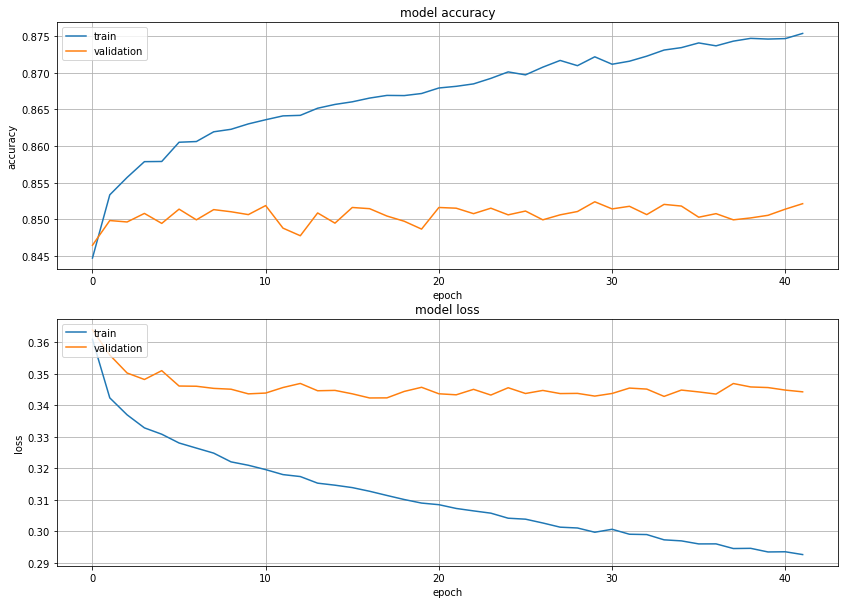

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
ax1.grid()

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')
ax2.grid()

In [12]:
y_prob = model.predict(X_test.drop(columns=["Location"]))

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


              precision    recall  f1-score   support

           0       0.89      0.95      0.92     40924
           1       0.72      0.54      0.62     10468

    accuracy                           0.86     51392
   macro avg       0.81      0.75      0.77     51392
weighted avg       0.86      0.86      0.86     51392



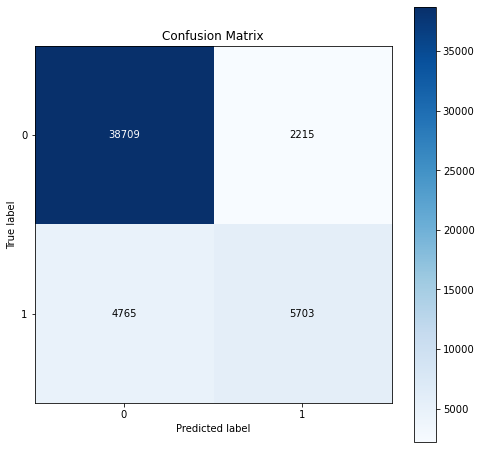

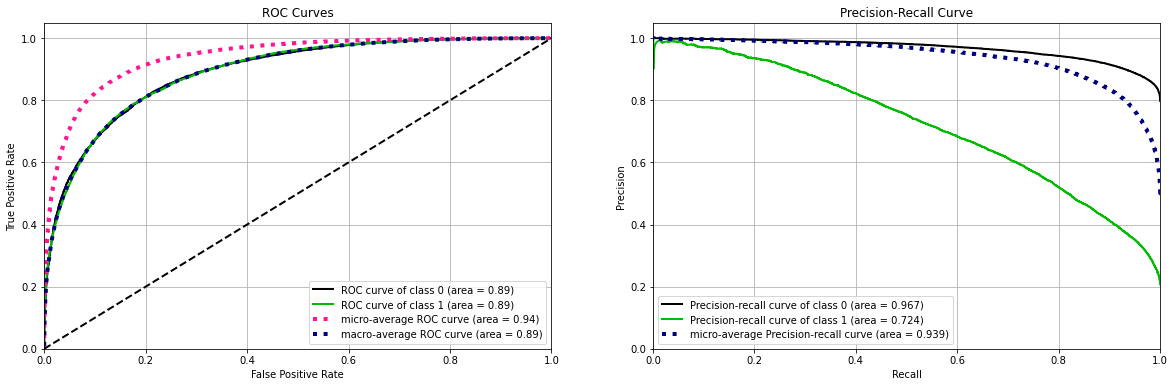

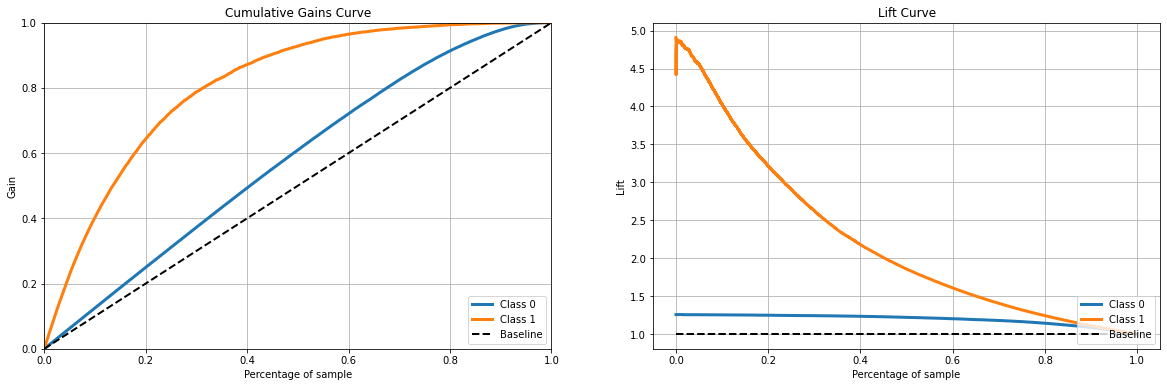

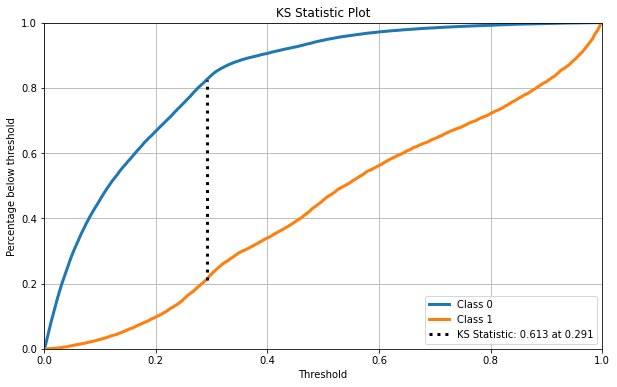

In [13]:
utils.evaluate_binary_clf(
    X_test.drop(columns=["Location"]),
    y_test,
    model=model,
    y_pred=(y_prob > 0.5).astype("int32").flatten(),
    y_prob=np.hstack((1 - y_prob, y_prob))
)

# Evaluating on train set to check for overfitting

/Users/ajaypethani/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


              precision    recall  f1-score   support

           0       0.89      0.96      0.92     95954
           1       0.80      0.56      0.66     27386

    accuracy                           0.87    123340
   macro avg       0.84      0.76      0.79    123340
weighted avg       0.87      0.87      0.86    123340



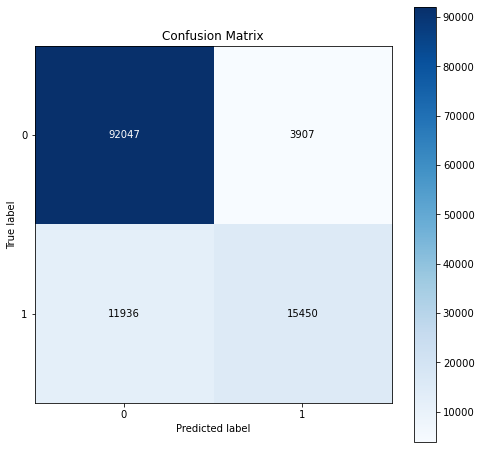

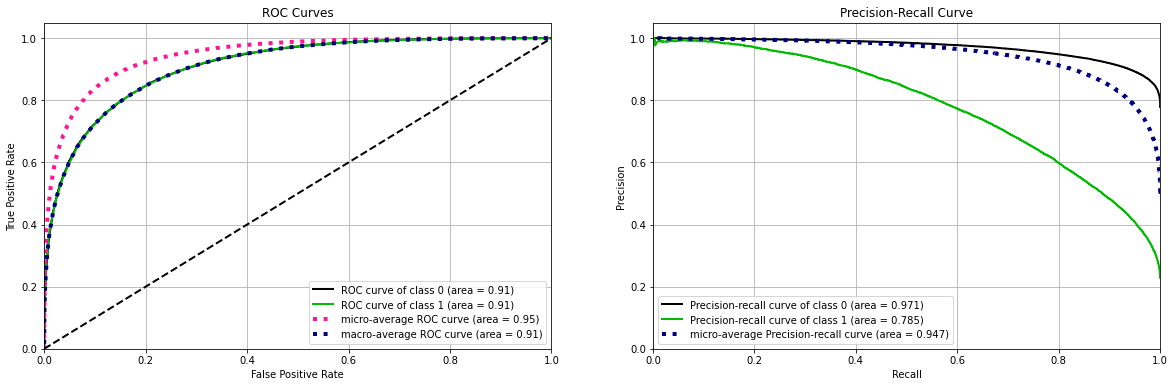

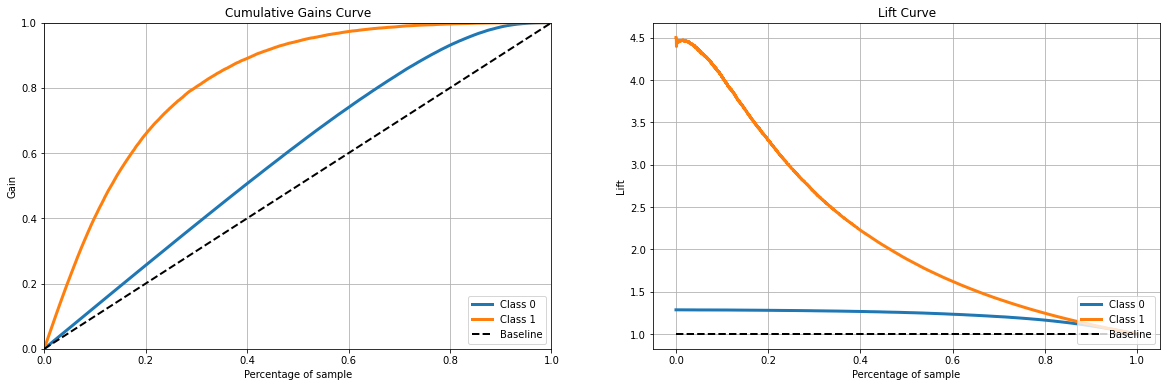

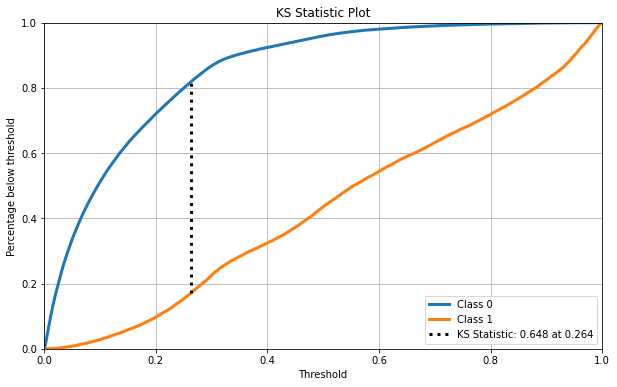

In [14]:
y_prob_train = model.predict(X_train.drop(columns=["Location"]))

utils.evaluate_binary_clf(
    X_train.drop(columns=["Location"]),
    y_train,
    model=model,
    y_pred=(y_prob_train > 0.5).astype("int32").flatten(),
    y_prob=np.hstack((1 - y_prob_train, y_prob_train))
)